In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import math
import seaborn as sns
import sklearn as skl
import scikitplot as skplt
import warnings
import matplotlib.pyplot as plt
import csv

In [2]:
warnings.simplefilter('ignore')

# Import dataset

In [3]:
df = pd.read_excel(r'/home/miguel/MEGA/FCUP/2020-2021/1stSemester/Introdução à ciência de dados/Project/UCMF.xls')

In [4]:
df.head()

,ID,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,...,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
0,1,5.0,51,19.0,11/05/06,30/03/06,0.12,GS,Normais,NaN,...,Não Calculado,Anormal,Normal,Sistólico,112,Palpitacao,NaN,M,6 - Suspeita de cardiopatia,6 - Palpitação/taquicardia/arritmia
1,2,3.5,50,14.0,25/05/05,19/05/05,0.02,GS,Normais,NaN,...,Não Calculado,Anormal,Normal,ausente,128,Dispneia,NaN,M,6 - Suspeita de cardiopatia,6 - Dispnéia
2,3,0.0,0,NaN,12/06/01,08/05/05,-4.05,SULA,Normais,NaN,...,Não Calculado,Anormal,Normal,Sistólico,88,Assintomático,NaN,M,2 - Check-up,NaN
3,4,8.1,65,19.0,15/10/09,21/04/09,0.50,NaN,Normais,NaN,...,Não Calculado,Anormal,Normal,ausente,92,Assintomático,NaN,M,5 - Parecer cardiológico,NaN
4,5,39.5,142,20.0,23/01/09,24/10/99,9.60,Sulam,Normais,85.0,...,Normal,Anormal,Normal,ausente,90,NaN,NaN,M,5 - Parecer cardiológico,5 - Atividade física


In [5]:
weight_0_36 = pd.read_excel(r'/home/miguel/MEGA/FCUP/2020-2021/1stSemester/Introdução à ciência de dados/Project/Complementary material/wtageinf.xls')
height_0_36 = pd.read_excel(r'/home/miguel/MEGA/FCUP/2020-2021/1stSemester/Introdução à ciência de dados/Project/Complementary material/lenageinf.xls')
weight_2_20 = pd.read_excel(r'/home/miguel/MEGA/FCUP/2020-2021/1stSemester/Introdução à ciência de dados/Project/Complementary material/wtage.xls')
height_2_20 = pd.read_excel(r'/home/miguel/MEGA/FCUP/2020-2021/1stSemester/Introdução à ciência de dados/Project/Complementary material/statage.xls')

bmi_2_20 = pd.read_excel(r'/home/miguel/MEGA/FCUP/2020-2021/1stSemester/Introdução à ciência de dados/Project/Complementary material/bmiagerev.xls')

# Remoção da columa ID

In [6]:
df = df.drop(columns='ID') #remoção da coluna ID

# Tratamento Atendimento, DN e IDADE

In [7]:
df = df[df['IDADE'].notna()] #remoção de NaN de idade
df = df[df['IDADE']!='#VALUE!'] #remoção de #VALUE de idade. Nestes casos ou a data de atendimento ou de nascença é inválida.
df['IDADE']=df['IDADE'].astype(float)
df = df[df['IDADE']>0.0] #remoção dos valores negativos de idade e maiores que 20 anos
df = df[df['IDADE']<20.0]

df = df[df['Atendimento'].notna()] #remoção de NaN de atendimento. assume-se que não foram atendidos. Não é ncessário para o problema.
df = df.drop(columns='Atendimento') #remoção da coluna atendimento

df = df[df['DN'].notna()] #remoção de NaN de data de nascimento. Não é ncessário para o problema.
df = df.drop(columns='DN') #remoção da coluna DN

df = df.sample(frac=1).reset_index(drop=True)

In [8]:
df.describe()

,Peso,Altura,IMC,IDADE,PA SISTOLICA,PA DIASTOLICA
count,15690.000000,15991.000000,12450.000000,15991.000000,9648.000000,9639.000000
mean,22.438292,89.161841,17.815743,6.340258,101.101265,62.181139
std,17.544202,54.135192,12.280321,4.631346,12.716165,8.760064
min,-40.000000,0.000000,0.000000,0.010000,10.000000,6.000000
25%,9.700000,53.000000,15.000000,2.390000,90.000000,60.000000
50%,19.000000,103.000000,17.000000,5.760000,100.000000,60.000000
75%,32.000000,132.000000,19.000000,9.995000,110.000000,70.000000
max,157.000000,198.000000,848.000000,19.840000,700.000000,120.000000


## Tratamento SEXO

In [9]:
df['SEXO'] = df['SEXO'].fillna('Indeterminado')
df['SEXO'] = df['SEXO'].replace({'Masculino':'M', 'Feminino':'F', 'masculino':'M'})
df = df[(df['SEXO']=='M') | (df['SEXO']=='F')] #remoção dos indeterminados

# Tratamento Peso, Altura e IMC

In [10]:
m_weight_0_36 = weight_0_36[(weight_0_36['Sex']==1) & (weight_0_36['Agemos']!=0.0)]
f_weight_0_36 = weight_0_36[(weight_0_36['Sex']==2) & (weight_0_36['Agemos']!=0.0)]
m_height_0_36 = height_0_36[(height_0_36['Sex']==1) & (weight_0_36['Agemos']!=0.0)]
f_height_0_36 = height_0_36[(height_0_36['Sex']==2) & (weight_0_36['Agemos']!=0.0)]

m_weight_2_20 = weight_2_20[(weight_2_20['Sex']==1) & (weight_2_20['Agemos']!=0.0)]
f_weight_2_20 = weight_2_20[(weight_2_20['Sex']==2) & (weight_2_20['Agemos']!=0.0)]
m_height_2_20 = height_2_20[(height_2_20['Sex']==1) & (weight_2_20['Agemos']!=0.0)]
f_height_2_20 = height_2_20[(height_2_20['Sex']==2) & (weight_2_20['Agemos']!=0.0)]

m_bmi_2_20 = bmi_2_20[(bmi_2_20['Sex']==1) & (bmi_2_20['Agemos']!=0.0)]
f_bmi_2_20 = bmi_2_20[(bmi_2_20['Sex']==2) & (bmi_2_20['Agemos']!=0.0)]


In [11]:
m_weight_0_36 = m_weight_0_36[m_weight_0_36['Agemos'].notna()]
f_weight_0_36 = f_weight_0_36[f_weight_0_36['Agemos'].notna()]
m_height_0_36 = m_height_0_36[m_height_0_36['Agemos'].notna()]
f_height_0_36 = f_height_0_36[f_height_0_36['Agemos'].notna()]

m_weight_2_20 = m_weight_2_20[m_weight_2_20['Agemos'].notna()]
f_weight_2_20 = f_weight_2_20[f_weight_2_20['Agemos'].notna()]
m_height_2_20 = m_height_2_20[m_height_2_20['Agemos'].notna()]
f_height_2_20 = f_height_2_20[f_height_2_20['Agemos'].notna()]


m_bmi_2_20 = m_bmi_2_20[m_bmi_2_20['Agemos'].notna()]
f_bmi_2_20 = f_bmi_2_20[f_bmi_2_20['Agemos'].notna()]


In [12]:
m_weight_0_36.loc[:,'Agemos'] = m_weight_0_36['Agemos'].astype(float)
f_weight_0_36.loc[:,'Agemos'] = f_weight_0_36['Agemos'].astype(float)
m_height_0_36.loc[:,'Agemos'] = m_height_0_36['Agemos'].astype(float)
f_height_0_36.loc[:,'Agemos'] = f_height_0_36['Agemos'].astype(float)

m_weight_2_20.loc[:,'Agemos'] = m_weight_2_20['Agemos'].astype(float)
f_weight_2_20.loc[:,'Agemos'] = f_weight_2_20['Agemos'].astype(float)
m_height_2_20.loc[:,'Agemos'] = m_height_2_20['Agemos'].astype(float)
f_height_2_20.loc[:,'Agemos'] = f_height_2_20['Agemos'].astype(float)

m_bmi_2_20.loc[:,'Agemos'] = m_bmi_2_20['Agemos'].astype(float)
f_bmi_2_20.loc[:,'Agemos'] = f_bmi_2_20['Agemos'].astype(float)

m_weight_0_36.loc[:,'P50'] = m_weight_0_36['P50'].astype(float)
f_weight_0_36.loc[:,'P50'] = f_weight_0_36['P50'].astype(float)
m_height_0_36.loc[:,'P50'] = m_height_0_36['P50'].astype(float)
f_height_0_36.loc[:,'P50'] = f_height_0_36['P50'].astype(float)

m_weight_2_20.loc[:,'P50'] = m_weight_2_20['P50'].astype(float)
f_weight_2_20.loc[:,'P50'] = f_weight_2_20['P50'].astype(float)
m_height_2_20.loc[:,'P50'] = m_height_2_20['P50'].astype(float)
f_height_2_20.loc[:,'P50'] = f_height_2_20['P50'].astype(float)

m_bmi_2_20.loc[:,'P50'] = m_bmi_2_20['P50'].astype(float)
f_bmi_2_20.loc[:,'P50'] = f_bmi_2_20['P50'].astype(float)

In [13]:
m_weight_0_36.loc[:,'Agemos'] = m_weight_0_36['Agemos'].div(12.0)
f_weight_0_36.loc[:,'Agemos'] = f_weight_0_36['Agemos'].div(12.0)
m_height_0_36.loc[:,'Agemos'] = m_height_0_36['Agemos'].div(12.0)
f_height_0_36.loc[:,'Agemos'] = f_height_0_36['Agemos'].div(12.0)

m_weight_2_20.loc[:,'Agemos'] = m_weight_2_20['Agemos'].div(12.0)
f_weight_2_20.loc[:,'Agemos'] = f_weight_2_20['Agemos'].div(12.0)
m_height_2_20.loc[:,'Agemos'] = m_height_2_20['Agemos'].div(12.0)
f_height_2_20.loc[:,'Agemos'] = f_height_2_20['Agemos'].div(12.0)

m_bmi_2_20.loc[:,'Agemos'] = m_bmi_2_20['Agemos'].div(12.0)
f_bmi_2_20.loc[:,'Agemos'] = f_bmi_2_20['Agemos'].div(12.0)


<AxesSubplot:xlabel='Agemos'>

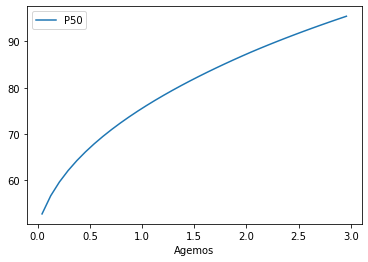

In [14]:
m_height_0_36.plot(x='Agemos', y='P50')

<AxesSubplot:xlabel='Agemos'>

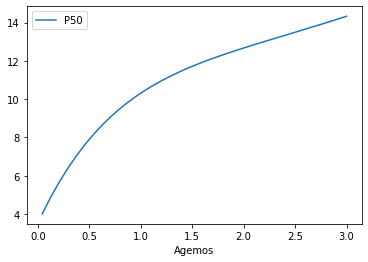

In [15]:
m_weight_0_36.plot(x='Agemos', y='P50')

<AxesSubplot:xlabel='Agemos'>

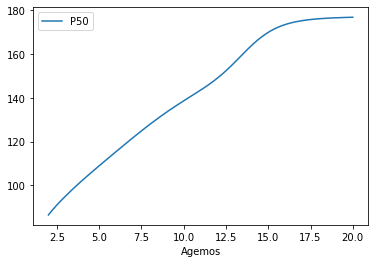

In [16]:
m_height_2_20.plot(x='Agemos', y='P50')

<AxesSubplot:xlabel='Agemos'>

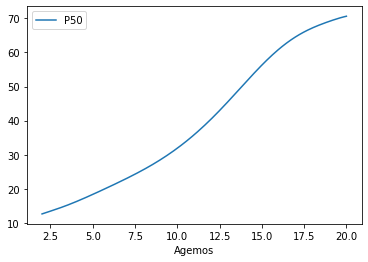

In [17]:
m_weight_2_20.plot(x='Agemos', y='P50')

<AxesSubplot:xlabel='Agemos'>

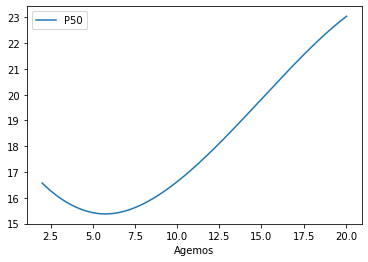

In [18]:
m_bmi_2_20.plot(x='Agemos', y='P50')

<AxesSubplot:xlabel='Agemos'>

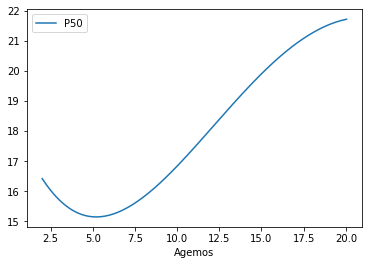

In [19]:
f_bmi_2_20.plot(x='Agemos', y='P50')

In [20]:
f_peso_idade1_curva = np.polyfit(f_weight_0_36['Agemos'], f_weight_0_36['P50'],2)
f_altr_idade1_curva = np.polyfit(f_height_0_36['Agemos'], f_height_0_36['P50'],2)
m_peso_idade1_curva = np.polyfit(m_weight_0_36['Agemos'], m_weight_0_36['P50'],2)
m_altr_idade1_curva = np.polyfit(m_height_0_36['Agemos'], m_height_0_36['P50'],2)

f_peso_idade2_curva = np.polyfit(f_weight_2_20['Agemos'], f_weight_2_20['P50'],2)
f_altr_idade2_curva = np.polyfit(f_height_2_20['Agemos'], f_height_2_20['P50'],2)
m_peso_idade2_curva = np.polyfit(m_weight_2_20['Agemos'], m_weight_2_20['P50'],2)
m_altr_idade2_curva = np.polyfit(m_height_2_20['Agemos'], m_height_2_20['P50'],2)

m_bmi_2_20_curva = np.polyfit(m_bmi_2_20['Agemos'], m_bmi_2_20['P50'], 3)
f_bmi_2_20_curva = np.polyfit(f_bmi_2_20['Agemos'], f_bmi_2_20['P50'], 3)


In [21]:
predict_f_peso_idade1 = np.poly1d(f_peso_idade1_curva)
predict_f_altr_idade1 = np.poly1d(f_altr_idade1_curva)
predict_m_peso_idade1 = np.poly1d(m_peso_idade1_curva)
predict_m_altr_idade1 = np.poly1d(m_altr_idade1_curva)

predict_f_peso_idade2 = np.poly1d(f_peso_idade2_curva)
predict_f_altr_idade2 = np.poly1d(f_altr_idade2_curva)
predict_m_peso_idade2 = np.poly1d(m_peso_idade2_curva)
predict_m_altr_idade2 = np.poly1d(m_altr_idade2_curva)

predict_m_bmi_2_20 = np.poly1d(m_bmi_2_20_curva)
predict_f_bmi_2_20 = np.poly1d(f_bmi_2_20_curva)


In [22]:
df1 = df['IDADE'][(df.loc[:,'Peso']<=0.0) & (df.loc[:,'IDADE'] < 3.0) & (df.loc[:,'SEXO'] == 'F')]
df['Peso'][(df.loc[:,'Peso']<=0.0) & (df.loc[:,'IDADE'] < 3.0) & (df.loc[:,'SEXO'] == 'F')] = predict_f_peso_idade1(df1)

df2 = df['IDADE'][(df.loc[:,'Peso']<=0.0) & (df.loc[:,'IDADE'] < 3.0) & (df.loc[:,'SEXO'] == 'M')]
df['Peso'][(df.loc[:,'Peso']<=0.0) & (df.loc[:,'IDADE'] < 3.0) & (df.loc[:,'SEXO'] == 'M')] = predict_m_peso_idade1(df2)

df3 = df['IDADE'][(df.loc[:,'Peso']<=0.0) & (df.loc[:,'IDADE'] >= 3.0) & (df.loc[:,'SEXO'] == 'F')]
df['Peso'][(df.loc[:,'Peso']<=0.0) & (df.loc[:,'IDADE'] >= 3.0) & (df.loc[:,'SEXO'] == 'F')] = predict_f_peso_idade2(df3)

df4 = df['IDADE'][(df.loc[:,'Peso']<=0.0) & (df.loc[:,'IDADE'] >= 3.0) & (df.loc[:,'SEXO'] == 'M')]
df['Peso'][(df.loc[:,'Peso']<=0.0) & (df.loc[:,'IDADE'] >= 3.0) & (df.loc[:,'SEXO'] == 'M')] = predict_m_peso_idade2(df4)

#########################################################################################################################

df5 = df['IDADE'][(df.loc[:,'Altura']<=0) & (df.loc[:,'IDADE'] < 3.0) & (df.loc[:,'SEXO'] == 'F')]
df['Altura'][(df.loc[:,'Altura']<=0) & (df.loc[:,'IDADE'] < 3.0) & (df.loc[:,'SEXO'] == 'F')] = predict_f_altr_idade1(df5)

df6 = df['IDADE'][(df.loc[:,'Altura']<=0) & (df.loc[:,'IDADE'] < 3.0) & (df.loc[:,'SEXO'] == 'M')]
df['Altura'][(df.loc[:,'Altura']<=0) & (df.loc[:,'IDADE'] < 3.0) & (df.loc[:,'SEXO'] == 'M')] = predict_m_altr_idade1(df6)

df7 = df['IDADE'][(df.loc[:,'Altura']<=0) & (df.loc[:,'IDADE'] >= 3.0) & (df.loc[:,'SEXO'] == 'F')]
df['Altura'][(df.loc[:,'Altura']<=0) & (df.loc[:,'IDADE'] >= 3.0) & (df.loc[:,'SEXO'] == 'F')] = predict_f_altr_idade2(df7)

df8 = df['IDADE'][(df.loc[:,'Altura']<=0) & (df.loc[:,'IDADE'] >= 3.0) & (df.loc[:,'SEXO'] == 'M')]
df['Altura'][(df.loc[:,'Altura']<=0) & (df.loc[:,'IDADE'] >= 3.0) & (df.loc[:,'SEXO'] == 'M')] = predict_m_altr_idade2(df8)

In [23]:
df.shape[0]

15587

In [24]:
def outls_w(data_m, data_f, min_age, max_age, tol):

    data_m['Agemos'] = round(data_m['Agemos'], 4)
    data_f['Agemos'] = round(data_f['Agemos'], 4)
    df.reset_index(drop=True, inplace=True)

    count = 0
    rows_to_drop = []
    for q in range(df.shape[0]):
            if((df['IDADE'].iloc[q] >= min_age) & (df['IDADE'].iloc[q] < max_age) & (df['SEXO'].iloc[q] == 'M')):
                # encontrar o p97 do valor mais proximo da idade na tabela de imputacao
                p97  = round (float (data_m.loc[(data_m['Agemos']==(min(data_m['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P97']), 3)
                p3   = round (float (data_m.loc[(data_m['Agemos']==(min(data_m['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P3']), 3)

                if((df['Peso'].iloc[q]) > (p97 *(1+tol/100))):
                    rows_to_drop.append (q)
                    count += 1
                    #print (df['IDADE'].iloc[q], df['Peso'].iloc[q] )

                elif((df['Peso'].iloc[q]) < (p3 *(1-tol/100))):
                    rows_to_drop.append (q)
                    count += 1
                    
            elif((df['IDADE'].iloc[q] >= min_age) & (df['IDADE'].iloc[q] < max_age) & (df['SEXO'].iloc[q] == 'F')):
                # encontrar o p97 do valor mais proximo da idade na tabela de imputacao
                p97  = round (float (data_f.loc[(data_f['Agemos']==(min(data_f['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P97']), 3)
                p3   = round (float (data_f.loc[(data_f['Agemos']==(min(data_f['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P3']), 3)

                if((df['Peso'].iloc[q]) > (p97 *(1+tol/100))):
                    rows_to_drop.append (q)
                    count += 1
                    #print (df['IDADE'].iloc[q], df['Peso'].iloc[q] )

                elif((df['Peso'].iloc[q]) < (p3 *(1-tol/100))):
                    rows_to_drop.append (q)
                    count += 1
    print (count)
    print('ok')
    return rows_to_drop
    
    

In [25]:
def outls_h(data_m, data_f, min_age, max_age, tol):
    data_f['Agemos'] = round(data_f['Agemos'], 4)
    df.reset_index(drop=True, inplace=True)

    count = 0
    rows_to_drop = []
    for q in range(df.shape[0]):
            if((df['IDADE'].iloc[q] >= min_age) & (df['IDADE'].iloc[q] < max_age) & (df['SEXO'].iloc[q] == 'M')):
                # encontrar o p97 do valor mais proximo da idade na tabela de imputacao
                p97  = round (float (data_m.loc[(data_m['Agemos']==(min(data_m['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P97']), 3)
                p3   = round (float (data_m.loc[(data_m['Agemos']==(min(data_m['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P3']), 3)

                if((df['Altura'].iloc[q]) > (p97 *(1+tol/100))):
                    rows_to_drop.append (q)
                    count += 1
                    #print (df['IDADE'].iloc[q], df['Peso'].iloc[q] )

                elif((df['Altura'].iloc[q]) < (p3 *(1-tol/100))):
                    rows_to_drop.append (q)
                    count += 1
                    
            elif((df['IDADE'].iloc[q] >= min_age) & (df['IDADE'].iloc[q] < max_age) & (df['SEXO'].iloc[q] == 'F')):
                # encontrar o p97 do valor mais proximo da idade na tabela de imputacao
                p97  = round (float (data_f.loc[(data_f['Agemos']==(min(data_f['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P97']), 3)
                p3   = round (float (data_f.loc[(data_f['Agemos']==(min(data_f['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P3']), 3)

                if((df['Altura'].iloc[q]) > (p97 *(1+tol/100))):
                    rows_to_drop.append (q)
                    count += 1
                    #print (df['IDADE'].iloc[q], df['Peso'].iloc[q] )

                elif((df['Altura'].iloc[q]) < (p3 *(1-tol/100))):
                    rows_to_drop.append (q)
                    count += 1
    print (count)
    print('ok')
    return rows_to_drop

In [26]:
rows = outls_w(m_weight_0_36, f_weight_0_36, 0, 3, 20)
df = df.drop(rows)
df = df.sample(frac=1).reset_index(drop=True)

253
ok


In [27]:
rows = outls_h(m_height_0_36, f_height_0_36, 0, 3, 20)
df = df.drop(rows)
df = df.sample(frac=1).reset_index(drop=True)

16
ok


In [28]:
rows = outls_w(m_weight_2_20, f_weight_2_20, 3, 20, 20)
df = df.drop(rows)
df = df.sample(frac=1).reset_index(drop=True)

359
ok


In [29]:
rows = outls_h(m_height_2_20, f_height_2_20, 3, 20, 20)
df = df.drop(rows)
df = df.sample(frac=1).reset_index(drop=True)

20
ok


In [30]:
df.shape[0]

14939

In [31]:
df

,Peso,Altura,IMC,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
0,9.900000,72,19.0,0.89,Sul America,Normais,NaN,NaN,Não Calculado,Anormal,Normal,Sistólico,112,Assintomático,NaN,M,1 - Cardiopatia já estabelecida,6 - Palpitação/taquicardia/arritmia
1,22.000000,118,16.0,7.06,NaN,Normais,105.0,60.0,Normal,Anormal,Normal,Sistólico,90,Dispneia,NaN,M,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
2,11.500000,76,20.0,1.30,NaN,Normais,NaN,NaN,Não Calculado,Normal,Normal,ausente,96,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Cirurgia
3,13.500000,80,21.0,1.24,NaN,Normais,NaN,NaN,Não Calculado,Anormal,Normal,Sistólico,100,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Cirurgia
4,4.768631,55,NaN,0.09,Norclínicas,Normais,NaN,NaN,Não Calculado,Normal,Normal,ausente,120,NaN,NaN,F,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14934,20.000000,112,NaN,5.59,FUSEX,Normais,100.0,45.0,Não Calculado,Normal,Normal,ausente,80,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Cirurgia
14935,32.760258,138,NaN,9.68,GRUPO,Normais,85.0,45.0,Não Calculado,Normal,Normal,ausente,78,Assintomático,NaN,M,5 - Parecer cardiológico,NaN
14936,10.000000,78,16.0,1.07,NaN,Normais,NaN,NaN,Não Calculado,Normal,Normal,ausente,78,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Cirurgia
14937,101.000000,181,31.0,18.78,NaN,Normais,120.0,75.0,NaN,Normal,Normal,ausente,NaN,Assintomático,NaN,F,5 - Parecer cardiológico,NaN


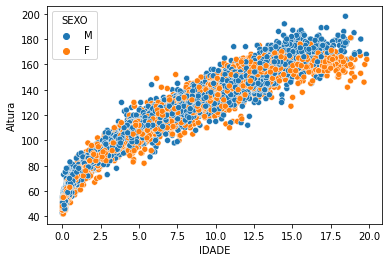

In [32]:
sns.scatterplot(x="IDADE", y="Altura",
              hue="SEXO",
              data=df);

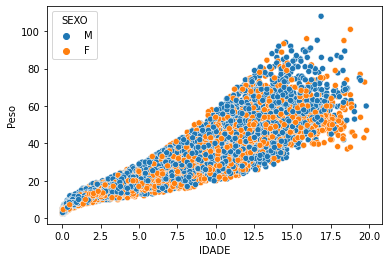

In [33]:
sns.scatterplot(x="IDADE", y="Peso",
              hue="SEXO",
              data=df);

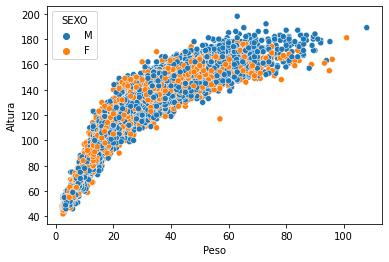

In [34]:
sns.scatterplot(x="Peso", y="Altura",
              hue="SEXO",
              data=df);

In [35]:
df.loc[:,'IMC'] = df['Peso']/((df['Altura']/100)**2)

In [36]:
df = df[df['IMC']<50]

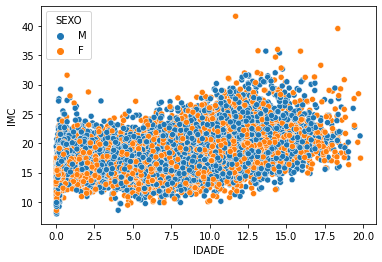

In [37]:
sns.scatterplot(x="IDADE", y="IMC",
              hue="SEXO",
              data=df);

# Tratamento Convenio

In [38]:
df = df.drop(columns='Convenio') #Não é necessário ao problema

# Tratamento Pulsos

In [39]:
df = df.drop(columns='PULSOS') #Não é necessário ao problema

# Tratamento NORMAL x ANORMAL

In [40]:
df['NORMAL X ANORMAL'] = df['NORMAL X ANORMAL'].str.replace('anormal','Anormal')
df['NORMAL X ANORMAL'] = df['NORMAL X ANORMAL'].str.replace('Normais','Normal')

# Tratamento SOPRO

## Transformação das variáveis diferentes de "ausente"

In [42]:
df['SOPRO'].value_counts()

ausente                   9319
Sistólico                 3993
sistólico                  938
contínuo                    22
Contínuo                    15
diastólico                   9
Sistolico e diastólico       3
Name: SOPRO, dtype: int64

Do ponto de vista do exercício, para apurar se existe patologia cardíaca ou não, só interessa a presença ou não do sopro. Concluíndo, podemos reduzir a variável SOPRO a uma variável binária: {ausente, presente}.

In [43]:
df['SOPRO'] = df['SOPRO'].replace({'sistólico':'Sistólico', 'contínuo':'Contínuo'})

In [44]:
df['SOPRO'] = df['SOPRO'].replace({'Sistólico':'presente', 'Contínuo':'presente', 'diastólico':'presente', 'Sistolico e diastólico':'presente'})

In [45]:
df['SOPRO'].value_counts()

ausente     9319
presente    4980
Name: SOPRO, dtype: int64

# Tratamento FC

In [46]:
def testKNN_r(df_prev, df_obj, std):
    x = df_prev
    y = df_obj
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    from sklearn.preprocessing import normalize
    
    if std == 1:
        x = sc.fit_transform(x)
    else:
        x = normalize(x)
    
    errors = []
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size = 0.25, random_state = 0)
    k_ok = 0
    
    gain = 0
    regressor = KNeighborsRegressor(n_neighbors = 1)
    regressor.fit(X_train,Y_train)
    error_0 = round(mean_absolute_error(Y_test,regressor.predict(X_test)),3)
    
    for k in range (1,20,2):
        regressor = KNeighborsRegressor(n_neighbors = k)
        regressor.fit(X_train,Y_train)
        error = round(mean_absolute_error(Y_test,regressor.predict(X_test)),3)
        gain = round(error_0 - error,3)
        error_0 = error
        errors.append({'K':k, 'mae':error, 'gain':gain})
    
    print(errors)

In [47]:
#df['FC'] = df['FC'].astype('str')
df.FC.unique()

array([112, 90, 96, 100, 120, 78, 92, nan, 76, 75, 82, 68, 70, 110, 80,
       130, 84, 88, 86, 72, 98, 94, 160, 188, 140, 74, 85, 108, 102, 60,
       104, 170, 135, 136, 132, 150, 128, 142, 64, 95, 62, '140-200', 122,
       115, 89, 50, 116, 124, 105, '140-120', 114, 145, 10, '170-150',
       125, 200, 138, 48, 152, 52, 123, 133, 65, 56, 109, 66, 148, 146,
       55, 8096, 144, 180, 79, 57, 156, 154, 93, '200-300', 1560, 134,
       118, '120-180', 97, 9288, '92-100', 106, 214, 137, 300, '50-100',
       182, '65-100', 230, 99, 126, 111, 780, 91, 81, 164, 16, '60-100',
       165, 192, '156 a 168', 900, 194, '140-160', 43, 801, 87, 12,
       '66-80', 972, '140-150', 107, 129, 83, 69, 73, 981, 1120],
      dtype=object)

In [48]:
import re
for i in range(df.shape[0]):
    if type(df['FC'].iloc[i]) == str:
        v = re.findall(r'\d+', df['FC'].iloc[i]) #retorna um vector com os valores númericos encontrados. Ex: 120-140 --> 120;140
        v = [int(k) for k in v]
        df['FC'].iloc[i] = int(abs(v[1]-v[0])/2) #calcula o valor intermédio entre os dois valores e guarda

df = df.sample(frac=1).reset_index(drop=True)

In [49]:
df2 = df
df2 = df2[df2['FC'].notna()]
df2 = df2.sample(frac=1).reset_index(drop=True)
df2['FC'] = df2['FC'].astype(int)
df2

,Peso,Altura,IMC,IDADE,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
0,18.000000,100,18.000000,3.14,NaN,NaN,Não Calculado,Anormal,Normal,presente,96,Assintomático,NaN,M,6 - Suspeita de cardiopatia,6 - Sopro
1,18.082965,107,15.794362,4.84,NaN,NaN,Não Calculado,Normal,Normal,ausente,96,NaN,NaN,F,5 - Parecer cardiológico,5 - Cirurgia
2,25.000000,117,18.262839,5.96,100.0,60.0,Normal,Anormal,Normal,presente,88,Assintomático,NaN,F,6 - Suspeita de cardiopatia,6 - Sopro
3,31.000000,130,18.343195,8.88,100.0,60.0,Normal,Normal,Normal,ausente,80,NaN,NaN,M,5 - Parecer cardiológico,5 - Cirurgia
4,14.500000,97,15.410777,3.67,NaN,NaN,Não Calculado,Normal,Normal,ausente,100,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Cirurgia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13616,15.000000,76,25.969529,1.25,NaN,NaN,Não Calculado,Normal,Normal,ausente,92,NaN,NaN,M,5 - Parecer cardiológico,5 - Cirurgia
13617,13.000000,78,21.367521,0.86,NaN,NaN,Não Calculado,Anormal,Normal,presente,120,Assintomático,NaN,M,5 - Parecer cardiológico,NaN
13618,37.000000,150,16.444444,11.79,100.0,60.0,Não Calculado,Normal,Normal,ausente,72,NaN,NaN,M,5 - Parecer cardiológico,5 - Atividade física
13619,57.000000,148,26.022644,10.99,120.0,80.0,Pre-Hipertensão PAS,Normal,Normal,ausente,80,Assintomático,NaN,F,6 - Suspeita de cardiopatia,6 - HAS/dislipidemia/obesidade


<AxesSubplot:>

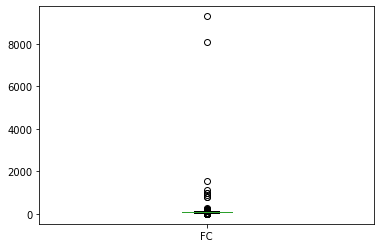

In [50]:
df['FC'].plot.box()

In [51]:
df = df[df['FC'] <= 230] #Valor máximo de frequência cardíaca
df = df.sample(frac=1).reset_index(drop=True)

In [52]:
df2 = df2[df2['FC'] <= 230]
df2 = df2.sample(frac=1).reset_index(drop=True)

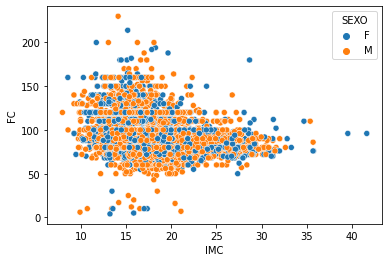

In [53]:
sns.scatterplot(x="IMC", y="FC",
              hue="SEXO",
              data=df);

In [54]:
X = df2[['IMC','IDADE']]
Y = df2['FC']

In [55]:
testKNN_r(X,Y,1)

[{'K': 1, 'mae': 12.021, 'gain': 0.0}, {'K': 3, 'mae': 10.311, 'gain': 1.71}, {'K': 5, 'mae': 9.766, 'gain': 0.545}, {'K': 7, 'mae': 9.473, 'gain': 0.293}, {'K': 9, 'mae': 9.288, 'gain': 0.185}, {'K': 11, 'mae': 9.211, 'gain': 0.077}, {'K': 13, 'mae': 9.117, 'gain': 0.094}, {'K': 15, 'mae': 9.046, 'gain': 0.071}, {'K': 17, 'mae': 9.035, 'gain': 0.011}, {'K': 19, 'mae': 8.998, 'gain': 0.037}]


In [56]:
testKNN_r(X,Y,0)

[{'K': 1, 'mae': 12.683, 'gain': 0.0}, {'K': 3, 'mae': 10.568, 'gain': 2.115}, {'K': 5, 'mae': 9.941, 'gain': 0.627}, {'K': 7, 'mae': 9.687, 'gain': 0.254}, {'K': 9, 'mae': 9.51, 'gain': 0.177}, {'K': 11, 'mae': 9.374, 'gain': 0.136}, {'K': 13, 'mae': 9.302, 'gain': 0.072}, {'K': 15, 'mae': 9.268, 'gain': 0.034}, {'K': 17, 'mae': 9.228, 'gain': 0.04}, {'K': 19, 'mae': 9.212, 'gain': 0.016}]


In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.25, random_state = 0)

In [58]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [59]:
from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors = 9)
regressor.fit(X_train, Y_train)

KNeighborsRegressor(n_neighbors=9)

In [60]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [61]:
mse = mean_squared_error(Y_test, regressor.predict(X_test))
mae = mean_absolute_error(Y_test, regressor.predict(X_test))
rmse = mean_squared_error(Y_test, regressor.predict(X_test), squared = False)

In [117]:
print("MSE: ",round(mse,3),"\nMAE: ", round(mae,3), "\nRMSE: ", round(rmse,3))

MSE:  163.167 
MAE:  9.287 
RMSE:  12.774


In [63]:
for k in range(df.shape[0]): #em todo as linhas
    if pd.isnull(df['FC'].iloc[k]):   #caso um valor de FC seja NaN
        Q = df[['IMC','IDADE']].iloc[k]
        df['FC'].iloc[k] = regressor.predict(Q)

In [64]:
df = df[df['FC'] >= 40]  #Valor mínimo de frequência cardiaca

<AxesSubplot:>

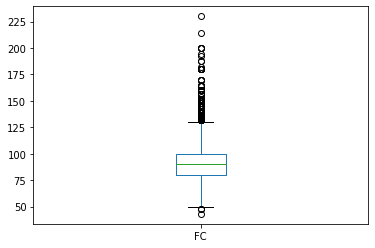

In [65]:
df['FC'].plot.box()

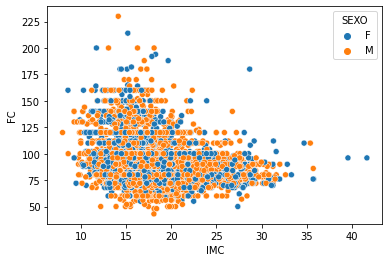

In [66]:
sns.scatterplot(x="IMC", y="FC",
              hue="SEXO",
              data=df);

## Tratamento HDA 1

In [67]:
df['HDA 1'] = df['HDA 1'].fillna('Sem histórico')

In [68]:
df['HDA 1'].value_counts()

Assintomático      7873
Sem histórico      3079
Dor precordial      748
Dispneia            621
Palpitacao          504
Desmaio/tontura     240
Cianose             236
Outro               177
Ganho de peso       116
Name: HDA 1, dtype: int64

In [69]:
df['HDA 1'].unique()

array(['Assintomático', 'Sem histórico', 'Palpitacao', 'Dor precordial',
       'Outro', 'Dispneia', 'Desmaio/tontura', 'Cianose', 'Ganho de peso'],
      dtype=object)

## Tratamento HDA2

In [70]:
df['HDA2'] = df['HDA2'].fillna('Sem histórico')

In [71]:
df['HDA2'].value_counts()

Sem histórico      13055
Palpitacao           134
Dispneia             110
Dor precordial        86
Cianose               65
Desmaio/tontura       61
Outro                 56
Ganho de peso         26
Assintomático          1
Name: HDA2, dtype: int64

In [72]:
df['HDA2'].unique()

array(['Sem histórico', 'Outro', 'Dor precordial', 'Dispneia',
       'Palpitacao', 'Desmaio/tontura', 'Ganho de peso', 'Cianose',
       'Assintomático'], dtype=object)

In [73]:
df[df['PA SISTOLICA']<500]
df = df.sample(frac=1).reset_index(drop=True)

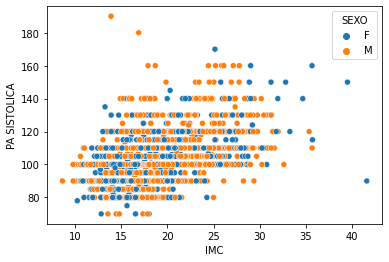

In [74]:
sns.scatterplot(x="IMC", y="PA SISTOLICA",
              hue="SEXO",
              data=df[(df['PA SISTOLICA']<500) & (df['PA SISTOLICA']>60)]);

## PA_SISTÓLICA e PA_DIASTÓLICA

In [75]:
df3 = df
df3 = df3[(df3['PA SISTOLICA']<500) & (df3['PA SISTOLICA']>60) & (df3['PA DIASTOLICA']>20)]
df3 = df3[(df3['PA SISTOLICA'].notna()) & (df3['PA DIASTOLICA'].notna())]
df3 = df3.sample(frac=1).reset_index(drop=True)

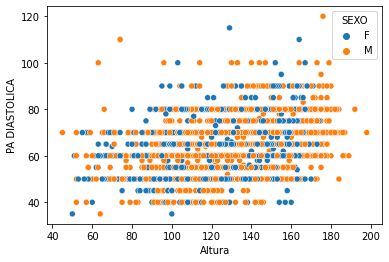

In [76]:
sns.scatterplot(x="Altura", y="PA DIASTOLICA",
              hue="SEXO",
              data=df3);

In [77]:
Z = df3[['Peso','Altura','IDADE']]
W = df3[['PA SISTOLICA']]

In [78]:
testKNN_r(Z,W,1)

[{'K': 1, 'mae': 8.825, 'gain': 0.0}, {'K': 3, 'mae': 7.578, 'gain': 1.247}, {'K': 5, 'mae': 7.266, 'gain': 0.312}, {'K': 7, 'mae': 7.069, 'gain': 0.197}, {'K': 9, 'mae': 6.928, 'gain': 0.141}, {'K': 11, 'mae': 6.837, 'gain': 0.091}, {'K': 13, 'mae': 6.791, 'gain': 0.046}, {'K': 15, 'mae': 6.775, 'gain': 0.016}, {'K': 17, 'mae': 6.762, 'gain': 0.013}, {'K': 19, 'mae': 6.749, 'gain': 0.013}]


In [79]:
testKNN_r(Z,W,0)

[{'K': 1, 'mae': 8.663, 'gain': 0.0}, {'K': 3, 'mae': 7.497, 'gain': 1.166}, {'K': 5, 'mae': 7.206, 'gain': 0.291}, {'K': 7, 'mae': 7.057, 'gain': 0.149}, {'K': 9, 'mae': 6.897, 'gain': 0.16}, {'K': 11, 'mae': 6.836, 'gain': 0.061}, {'K': 13, 'mae': 6.762, 'gain': 0.074}, {'K': 15, 'mae': 6.725, 'gain': 0.037}, {'K': 17, 'mae': 6.688, 'gain': 0.037}, {'K': 19, 'mae': 6.706, 'gain': -0.018}]


In [80]:
from sklearn.model_selection import train_test_split
Z_train, Z_test, W_train, W_test = train_test_split(Z,W,test_size = 0.25, random_state = 0)

In [81]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Z_train = sc.fit_transform(Z_train)
Z_test = sc.transform(Z_test)

In [82]:
from sklearn.neighbors import KNeighborsRegressor
regressor2 = KNeighborsRegressor(n_neighbors = 7)
regressor2.fit(Z_train, W_train)

KNeighborsRegressor(n_neighbors=7)

In [83]:
mse2 = mean_squared_error(W_test, regressor2.predict(Z_test))
mae2 = mean_absolute_error(W_test, regressor2.predict(Z_test))
rmse2 = mean_squared_error(W_test, regressor2.predict(Z_test), squared = False)

In [118]:
print("MSE: ",round(mse2,3),"\nMAE: ", round(mae2,3), "\nRMSE: ", round(rmse2,3))

MSE:  84.663 
MAE:  7.077 
RMSE:  9.201


In [85]:
E = df3[['Peso','Altura','IDADE']]
R = df3[['PA DIASTOLICA']]

In [86]:
testKNN_r(E,R,1)

[{'K': 1, 'mae': 7.614, 'gain': 0.0}, {'K': 3, 'mae': 6.579, 'gain': 1.035}, {'K': 5, 'mae': 6.296, 'gain': 0.283}, {'K': 7, 'mae': 6.112, 'gain': 0.184}, {'K': 9, 'mae': 6.01, 'gain': 0.102}, {'K': 11, 'mae': 5.972, 'gain': 0.038}, {'K': 13, 'mae': 5.917, 'gain': 0.055}, {'K': 15, 'mae': 5.871, 'gain': 0.046}, {'K': 17, 'mae': 5.85, 'gain': 0.021}, {'K': 19, 'mae': 5.818, 'gain': 0.032}]


In [87]:
testKNN_r(E,R,0)

[{'K': 1, 'mae': 7.426, 'gain': 0.0}, {'K': 3, 'mae': 6.557, 'gain': 0.869}, {'K': 5, 'mae': 6.296, 'gain': 0.261}, {'K': 7, 'mae': 6.109, 'gain': 0.187}, {'K': 9, 'mae': 6.024, 'gain': 0.085}, {'K': 11, 'mae': 5.926, 'gain': 0.098}, {'K': 13, 'mae': 5.881, 'gain': 0.045}, {'K': 15, 'mae': 5.822, 'gain': 0.059}, {'K': 17, 'mae': 5.786, 'gain': 0.036}, {'K': 19, 'mae': 5.777, 'gain': 0.009}]


In [88]:
E_train, E_test, R_train, R_test = train_test_split(E,R,test_size = 0.25, random_state = 0)

In [89]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
E_train = sc.fit_transform(E_train)
E_test = sc.transform(E_test)

In [90]:
from sklearn.neighbors import KNeighborsRegressor
regressor3 = KNeighborsRegressor(n_neighbors = 7)
regressor3.fit(E_train, R_train)

KNeighborsRegressor(n_neighbors=7)

In [91]:
mse3 = mean_squared_error(R_test, regressor3.predict(E_test))
mae3 = mean_absolute_error(R_test, regressor3.predict(E_test))
rmse3 = mean_squared_error(R_test, regressor3.predict(E_test), squared = False)

In [120]:
print("MSE: ",round(mse3,3),"\nMAE: ", round(mae3,3), "\nRMSE: ", round(rmse3,3))

MSE:  64.993 
MAE:  6.11 
RMSE:  8.062


In [93]:
for o in range(df.shape[0]): #em todo as linhas
    if pd.isnull((df['PA SISTOLICA'].iloc[o])):
        K = df[['Peso','Altura','IDADE']].iloc[o].values.reshape(1,-1)
        #K = K.values.reshape(1,-1)
        df['PA SISTOLICA'].iloc[o] = regressor2.predict(K)
    
    if pd.isnull((df['PA DIASTOLICA'].iloc[o])):
        Q = df[['Peso','Altura','IDADE']].iloc[o].values.reshape(1,-1)
        #Q = Q.values.reshape(1,-1)
        df['PA DIASTOLICA'].iloc[o] = regressor3.predict(Q)
        

In [94]:
df = df[(df['PA SISTOLICA']<200) & (df['PA SISTOLICA']>60) & (df['PA DIASTOLICA']>20)]

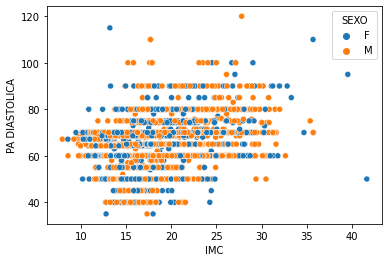

In [95]:
sns.scatterplot(x="IMC", y="PA DIASTOLICA",
              hue="SEXO",
              data=df);

<AxesSubplot:>

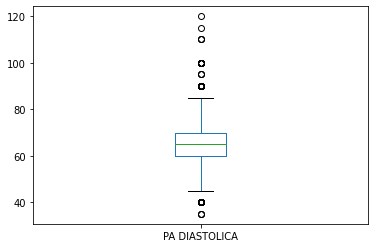

In [96]:
df['PA DIASTOLICA'].plot.box()

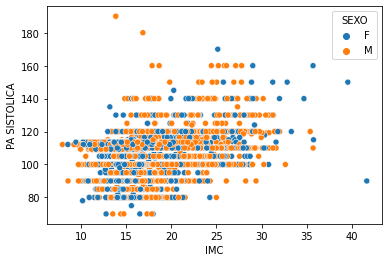

In [97]:
sns.scatterplot(x="IMC", y="PA SISTOLICA",
              hue="SEXO",
              data=df);

<AxesSubplot:>

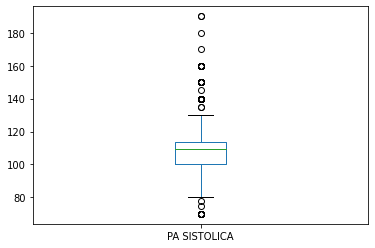

In [98]:
df['PA SISTOLICA'].plot.box()

In [99]:
df.shape[0]

13588

In [100]:
df = df[(df['B2'].notna()) & (df['NORMAL X ANORMAL'].notna())]

In [101]:
df = df.drop(columns='PPA') 

In [102]:
df['HDA 1'].value_counts()

Assintomático      7852
Sem histórico      3079
Dor precordial      748
Dispneia            620
Palpitacao          503
Desmaio/tontura     239
Cianose             234
Outro               177
Ganho de peso       116
Name: HDA 1, dtype: int64

In [103]:
df.isna().sum()

Peso                   0
Altura                 0
IMC                    0
IDADE                  0
PA SISTOLICA           0
PA DIASTOLICA          0
NORMAL X ANORMAL       0
B2                     0
SOPRO                  0
FC                     0
HDA 1                  0
HDA2                   0
SEXO                   0
MOTIVO1              120
MOTIVO2             3175
dtype: int64

In [104]:
dfx = df[df['HDA 1']== "Ganho de peso"]

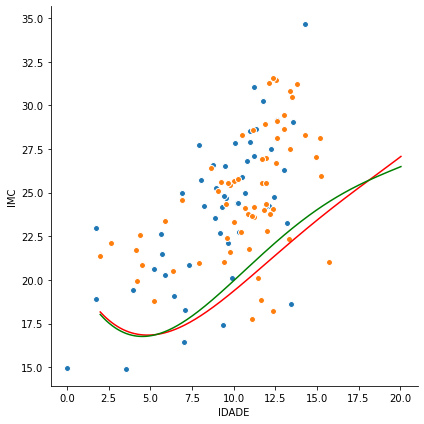

In [105]:
X_plot = m_bmi_2_20['Agemos']
Y_plot = m_bmi_2_20['P85']
X2_plot = f_bmi_2_20['Agemos']
Y2_plot = f_bmi_2_20['P85']
g = sns.FacetGrid(dfx, size = 6, hue = "SEXO")
g = g.map(plt.scatter, "IDADE", "IMC", edgecolor="w")
#m_bmi_2_20.plot(x='Agemos', y='P50')
plt.plot(X_plot, Y_plot, color='r')
plt.plot(X2_plot, Y2_plot, color='g')
plt.show()

In [106]:
df['HDA 1'][(df['MOTIVO2']=='6 - Dor precordial') & (df['HDA 1']=='Sem histórico')]='Dor precordial'

In [107]:
df['HDA 1'][(df['MOTIVO2']=='6 - Cianose') & (df['HDA 1']== 'Sem histórico')] = 'Cianose'

In [108]:
df.loc[(((df['HDA 1'].isna())) & (df['MOTIVO2']=='6 - Cianose e dispnéia')), 'HDA 1'] = "Cianose"
df.loc[(((df['HDA2'].isna())) & (df['MOTIVO2']=='6 - Cianose e dispnéia')), 'HDA2'] = "Dispneia"

In [109]:
def over_imc(data_m, data_f):
    data_f['Agemos'] = round(data_f['Agemos'], 4)
    df.reset_index(drop=True, inplace=True)

   
    for q in range(df.shape[0]):
            if((df['SEXO'].iloc[q] == 'M') & (df['HDA 1'].iloc[q] == 'Sem histórico')):
                # encontrar o p97 do valor mais proximo da idade na tabela de imputacao
                p85  = round (float (data_m.loc[(data_m['Agemos']==(min(data_m['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P85']), 3)
                #p3   = round (float (data_m.loc[(data_m['Agemos']==(min(data_m['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P3']), 3)

                if((df['IMC'].iloc[q]) > p85):
                    df['HDA 1'].iloc[q] = 'Ganho de peso'
                    #print (df['IDADE'].iloc[q], df['Peso'].iloc[q] )
                    #print('M added')
                                    
            elif((df['SEXO'].iloc[q] == 'F') & (df['HDA 1'].iloc[q] == 'Sem histórico')):
                # encontrar o p97 do valor mais proximo da idade na tabela de imputacao
                p85  = round (float (data_f.loc[(data_f['Agemos']==(min(data_f['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P85']), 3)
                #p3   = round (float (data_f.loc[(data_f['Agemos']==(min(data_f['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P3']), 3)

                if((df['IMC'].iloc[q]) > p85):
                    df['HDA 1'].iloc[q] = 'Ganho de peso'
                    #print (df['IDADE'].iloc[q], df['Peso'].iloc[q] )
                    #print('F added')
    

In [110]:
over_imc(m_bmi_2_20, f_bmi_2_20)

In [111]:
df = df.drop(columns = 'HDA2')
df.rename(columns={'HDA 1':'HDA'},inplace=True)

In [112]:
df.insert(14, "MOTIVO", np.nan)

In [113]:
for o in range(df.shape[0]):
    if ((str(df['MOTIVO2'].iloc[o])!= 'nan') & (str(df['MOTIVO2'].iloc[o])!= 'Outro')):
        if len(df[(df['MOTIVO1'] ==df['MOTIVO1'].iloc[o]) & (df['MOTIVO2'] == df['MOTIVO2'].iloc[o])]) >=90:
            df['MOTIVO'].iloc[o] = str(df['MOTIVO1'].iloc[o]) + ' (' + str(df['MOTIVO2'].iloc[o]) + ')'
        else:
            df['MOTIVO'].iloc[o] = str(df['MOTIVO1'].iloc[o])
    elif((str(df['MOTIVO1'].iloc[o]) == 'nan') | pd.isnull(df['MOTIVO1'].iloc[o])):
        df['MOTIVO'].iloc[o] = '7 - Outro'
    else:
        df['MOTIVO'].iloc[o] = str(df['MOTIVO1'].iloc[o])

In [114]:
df = df.drop(columns='MOTIVO1')
df = df.drop(columns='MOTIVO2') 

In [115]:
df.to_csv('/home/miguel/MEGA/FCUP/2020-2021/1stSemester/Introdução à ciência de dados/Project/df_final.csv', index=False)

In [116]:
df['MOTIVO'].value_counts()

5 - Parecer cardiológico (5 - Cirurgia)                              3596
6 - Suspeita de cardiopatia (6 - Sopro)                              2271
5 - Parecer cardiológico                                             2225
5 - Parecer cardiológico (5 - Atividade física)                       873
1 - Cardiopatia já estabelecida (1 - Cardiopatia congenica)           865
2 - Check-up                                                          838
6 - Suspeita de cardiopatia                                           708
6 - Suspeita de cardiopatia (6 - Dor precordial)                      523
7 - Outro                                                             464
6 - Suspeita de cardiopatia (6 - Palpitação/taquicardia/arritmia)     434
6 - Suspeita de cardiopatia (6 - Dispnéia)                            245
6 - Suspeita de cardiopatia (6 - HAS/dislipidemia/obesidade)          229
1 - Cardiopatia já estabelecida                                       169
6 - Suspeita de cardiopatia (6 - Ciano